# 토픽 모델링(Topic Modeling)

* 토픽 모델링은 문서 집합에서 주제를 찾아내기 위한 기술
* 토픽 모델링은 '특정 주제에 관한 문서에서는 특정 단어가 자주 등장할 것이다'라는 직관을 기반
* 예를 들어, 주제가 '개'인 문서에서는 개의 품종, 개의 특성을 나타내는 단어가 다른 문서에 비해 많이 등장
* 주로 사용되는 토픽 모델링 방법은 잠재 의미 분석과 잠재 디리클레 할당 기법이 있음

## 잠재 의미 분석(Latent Semantic Analysis)

* 잠재 의미 분석(LSA)은 주로 문서 색인의 의미 검색에 사용
* 잠재 의미 인덱싱(Latent Semantic Indexing, LSI)로도 알려져 있음
* LSA의 목표는 문서와 단어의 기반이 되는 잠재적인 토픽을 발견하는 것
* 잠재적인 토픽은 문서에 있는 단어들의 분포를 주도한다고 가정

* LSA 방법
  + 문서 모음에서 생성한 문서-단어 행렬(Document Term Matrix)에서 단어-토픽 행렬(Term-Topic Matrix)과 토픽-중요도 행렬(Topic-Importance Matrix), 그리고 토픽-문서 행렬(Topic-Document Matrix)로 분해

## 잠재 디리클레 할당(Latent Dirichlet Allocation)

* 잠재 디레클레 할당(LDA)은 대표적인 토픽 모델링  알고리즘 중 하나

* 잠재 디레클레 할당 방법
  1. 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 w가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

* $p(t|d)$ - 문서 d의 단어들 중 토픽 t에 해당하는 비율
* 해당 문서의 자주 등장하는 다른 단어의 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미    

* $p(w|t)$- 단어 w를 가지고 있는 모든 문서들 중  토픽 t가 할당된 비율
* 다른 문서에서 단어 w에 많이 할당된 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미

## 데이터 준비

In [1]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=123,
                          remove=('headers', 'footers', 'quotes'))
documents = dataset.data

print(len(documents))
documents[0]

11314


"A quick query for Powerbook gurus:\nTom Spearman, in a post on alternative Powerbook battery options\nmentioned that there exist 3 versions of their Powerbook 140-180\nbatteries: a 2.5 amp hour one (M5545/A), a 2.8 amp hour one,\n(M5545/B) and a 2.9 amp hour one (M5545/C). Anyone out there\nknow how to determine which of these a battery is? I looked at my\nbattery and there is no obvious exterior indication. I contacted\nTom Spearman who had gleaned the information from MacUser and he\ndidn't know either. Anyone out there know the answer?\n\tThanks!\n\tChristopher Majka\n\tnextug@ac.dal.ca"

In [2]:
#전처리
import re, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import preprocess_string

nltk.download('stopwords')

def clean_text(d):     #알파벳과 공백문자가 아닌 텍스트 삭제
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

def clean_stopword(d):
    stop_words = stopwords.words('english')
    result = ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w)>3])
    return result

def preprocessing(d):
    return preprocess_string(d)

C:\Users\master\anaconda3\envs\py38\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\master\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
print(len(news_df))

11314


In [4]:
news_df.replace('', float('NaN'), inplace=True)
news_df.dropna(inplace=True)
print(len(news_df))
print(news_df.head(5))

11096
                                             article
0  A quick query for Powerbook gurus:\nTom Spearm...
1  From article <1993Apr18.000152.2339@gnv.ifas.u...
2  \nSteve, take a look at what you are saying.  ...
3  I have a routine that changes the color (RGB) ...
4  \nI sometimes wonder if Kekule's dream wasn't ...


In [5]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article'] = news_df['article'].apply(clean_stopword)
print(news_df.head(5))

                                             article
0  quick query powerbook gurus spearman post alte...
1  article aprgnvifasufledu jrmgnvifasufledu irra...
2  steve take look saying dont construvtive word ...
3  routine changes color attributes adapter doesn...
4  sometimes wonder kekules dream wasnt influence...


In [6]:
tokenized_df = news_df['article'].apply(preprocessing).astype('object')
tokenized_array = tokenized_df.to_numpy()

In [7]:
import numpy as np

drop_news = [i for i, sentence in enumerate(tokenized_array) if len(sentence)<=1]
news_texts = np.delete(tokenized_array, drop_news, axis=0)

print(len(news_texts))

10926


## Gensim을 이용한 토픽 모델링

In [8]:
from gensim import corpora

dictionary = corpora.Dictionary(news_texts)
corpus = [dictionary.doc2bow(text) for text in news_texts]

corpus[0]

[(0, 1),
 (1, 1),
 (2, 4),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 3),
 (12, 1),
 (13, 1),
 (14, 3),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 3),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1)]

### 잠재 의미 분석을 위한 `LsiModel`

In [9]:
from gensim.models import LsiModel

lsi = LsiModel(corpus, num_topics=20, id2word=dictionary)
topics = lsi.print_topics()
topics

[(0,
  '-1.000*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxax" + -0.008*"mgvgvgvgvgvgvgvgvgvgvgvgvgvgvgv" + -0.005*"maxaxaxaxaxaxaxaxaxaxaxaxaxax" + -0.003*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxaxq" + -0.002*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxf" + -0.002*"mqaxaxaxaxaxaxaxaxaxaxaxaxaxax" + -0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxasqq" + -0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxqq" + -0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxasq" + -0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxqqf"'),
 (1,
  '0.393*"file" + 0.191*"program" + 0.158*"imag" + 0.126*"peopl" + 0.125*"avail" + 0.119*"inform" + 0.116*"includ" + 0.116*"entri" + 0.114*"work" + 0.112*"dont"'),
 (2,
  '0.456*"file" + -0.215*"peopl" + -0.210*"know" + -0.192*"said" + -0.176*"dont" + 0.158*"entri" + -0.158*"think" + -0.153*"stephanopoulo" + 0.139*"imag" + -0.129*"go"'),
 (3,
  '-0.409*"file" + -0.286*"entri" + 0.241*"imag" + 0.168*"avail" + 0.141*"wire" + 0.136*"data" + 0.122*"version" + -0.116*"onam" + 0.109*"window" + -0.104*"said"'),
 (4,
  '-0.618*"wire" + -0.250*"ground" + -0.18

In [10]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

min_topics, max_topics = 20, 25
coherence_scores = []

for num_topics in range(min_topics, max_topics):
    model = LsiModel(corpus, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=model, texts=news_texts, dictionary=dictionary)
    coherence_scores.append(coherence.get_coherence())

print(coherence_scores)

[0.41300891754055336, 0.42984793365313784, 0.37753027512448617, 0.4567000904517372, 0.4274552432196561]


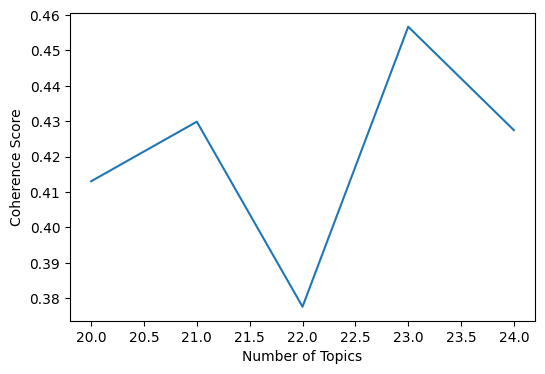

In [11]:
x = [int(i) for i in range(min_topics, max_topics)]
plt.figure(figsize=(6,4))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score');

In [12]:
lsi = LsiModel(corpus, num_topics=22, id2word=dictionary)
topics = lsi.print_topics(num_topics=22)
topics

[(0,
  '1.000*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.008*"mgvgvgvgvgvgvgvgvgvgvgvgvgvgvgv" + 0.005*"maxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.003*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxaxq" + 0.002*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxf" + 0.002*"mqaxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxasqq" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxqq" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxasq" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxqqf"'),
 (1,
  '0.393*"file" + 0.191*"program" + 0.158*"imag" + 0.126*"peopl" + 0.125*"avail" + 0.119*"inform" + 0.116*"includ" + 0.116*"entri" + 0.114*"work" + 0.112*"dont"'),
 (2,
  '-0.456*"file" + 0.215*"peopl" + 0.210*"know" + 0.192*"said" + 0.176*"dont" + -0.158*"entri" + 0.158*"think" + 0.153*"stephanopoulo" + -0.139*"imag" + 0.129*"go"'),
 (3,
  '0.409*"file" + 0.286*"entri" + -0.241*"imag" + -0.168*"avail" + -0.141*"wire" + -0.136*"data" + -0.122*"version" + 0.116*"onam" + -0.109*"window" + 0.104*"said"'),
 (4,
  '-0.618*"wire" + -0.250*"ground" + -0.188*"circuit" 

### 수동으로 해보기

In [16]:
news_texts

array([list(['quick', 'queri', 'powerbook', 'guru', 'spearman', 'post', 'altern', 'powerbook', 'batteri', 'option', 'mention', 'exist', 'version', 'powerbook', 'batteri', 'hour', 'hour', 'hour', 'know', 'determin', 'batteri', 'look', 'batteri', 'obviou', 'exterior', 'indic', 'contact', 'spearman', 'glean', 'inform', 'macus', 'didnt', 'know', 'know', 'answer', 'thank', 'christoph', 'majka', 'nextugacdalca']),
       list(['articl', 'aprgnvifasufledu', 'jrmgnvifasufledu', 'irrat', 'fool', 'rkba', 'plenti', 'peopl', 'support', 'govern', 'overthrown', 'long', 'happen', 'huge', 'millitia', 'compos', 'avail', 'women', 'care', 'countri', 'defeat', 'forc', 'evil', 'klintonista', 'peopl', 'prevail', 'think', 'arm', 'citizen', 'overthrow', 'govern', 'consid', 'think', 'enforc', 'offici', 'member', 'arm', 'forc', 'turn', 'peopl', 'entrust', 'serv', 'hardli', 'count', 'peopl', 'armi', 'marin', 'forc', 'navi', 'nation', 'guard', 'polic', 'offic', 'join', 'caus', 'defend', 'liberti', 'freedom', 'ame

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, # 상위 1,000개의 단어를 보존 
max_df = 0.5, smooth_idf=True)

X = vectorizer.fit_transform(news_texts)

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X.shape)

AttributeError: 'list' object has no attribute 'lower'

### 잠재 디리클레 할당을 위한 `LdaModel`

In [13]:
from gensim.models import LdaModel

lda = LdaModel(corpus, num_topics=20, id2word=dictionary)
topics = lda.print_topics()
topics

[(0,
  '0.014*"presid" + 0.006*"insur" + 0.006*"crime" + 0.005*"rate" + 0.005*"weapon" + 0.004*"year" + 0.004*"offic" + 0.004*"peopl" + 0.004*"know" + 0.004*"senat"'),
 (1,
  '0.018*"believ" + 0.018*"atheist" + 0.017*"belief" + 0.017*"exist" + 0.010*"atheism" + 0.007*"word" + 0.007*"christian" + 0.007*"evid" + 0.005*"reason" + 0.005*"mean"'),
 (2,
  '0.026*"church" + 0.019*"jesu" + 0.017*"christ" + 0.015*"father" + 0.012*"spirit" + 0.009*"pope" + 0.009*"holi" + 0.008*"believ" + 0.007*"cathol" + 0.007*"christian"'),
 (3,
  '0.007*"work" + 0.007*"time" + 0.007*"state" + 0.006*"dont" + 0.006*"peopl" + 0.005*"point" + 0.005*"right" + 0.005*"like" + 0.004*"know" + 0.004*"think"'),
 (4,
  '0.020*"simm" + 0.018*"greek" + 0.018*"bank" + 0.013*"turkish" + 0.013*"skeptic" + 0.012*"gordon" + 0.012*"shame" + 0.011*"surrend" + 0.011*"intellect" + 0.011*"njxp"'),
 (5,
  '0.006*"period" + 0.006*"post" + 0.005*"paul" + 0.005*"time" + 0.004*"organis" + 0.004*"group" + 0.004*"wood" + 0.003*"save" + 0.00

In [14]:
min_topics, max_topics = 20, 25
coherence_scores = []

for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=model, texts=news_texts, dictionary=dictionary)
    coherence_scores.append(coherence.get_coherence())
    
print(coherence_scores)

[0.5457706297959992, 0.5325576628928234, 0.5362726825946643, 0.493009266340066, 0.5153782011817587]


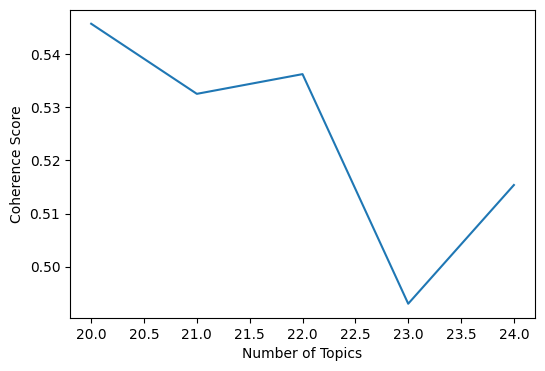

In [15]:
x = [int(i) for i in range(min_topics, max_topics)]
plt.figure(figsize=(6,4))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score');

In [16]:
lda = LdaModel(corpus, num_topics=21, id2word=dictionary)
topics = lda.print_topics(num_topics=21)
topics

[(0,
  '0.013*"christian" + 0.011*"believ" + 0.008*"think" + 0.008*"exist" + 0.007*"mean" + 0.006*"know" + 0.006*"belief" + 0.006*"truth" + 0.006*"church" + 0.006*"faith"'),
 (1,
  '0.017*"job" + 0.008*"know" + 0.008*"summer" + 0.007*"work" + 0.007*"presid" + 0.006*"dole" + 0.004*"price" + 0.004*"motorola" + 0.004*"need" + 0.004*"bathroom"'),
 (2,
  '0.014*"space" + 0.010*"anonym" + 0.010*"data" + 0.009*"internet" + 0.008*"technolog" + 0.008*"inform" + 0.007*"orbit" + 0.006*"develop" + 0.006*"avail" + 0.006*"servic"'),
 (3,
  '0.010*"dont" + 0.010*"like" + 0.009*"bike" + 0.008*"time" + 0.007*"brake" + 0.007*"know" + 0.007*"think" + 0.006*"year" + 0.006*"look" + 0.005*"ride"'),
 (4,
  '0.026*"armenian" + 0.010*"peopl" + 0.009*"turkish" + 0.008*"kill" + 0.007*"govern" + 0.005*"drug" + 0.005*"turkei" + 0.005*"said" + 0.005*"dont" + 0.004*"murder"'),
 (5,
  '0.007*"jew" + 0.006*"time" + 0.005*"peopl" + 0.005*"state" + 0.005*"right" + 0.005*"said" + 0.004*"kill" + 0.003*"second" + 0.003*"re

## 토픽 모델링 시각화

In [17]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)